# RNN in Jax

In [1]:
import jax
import jax.numpy as np
import math
import numpy as onp
import tensorflow as tf
import time
import matplotlib.pyplot as plt
from jax import grad, vmap, jit
import jax
import jax.numpy as np
import pandas as pd
import itertools
import functools
import os
from shutil import copy
from shutil import move
import pickle
from jax.config import config
config.update("jax_debug_nans", True)

In [2]:
key = jax.random.PRNGKey(1)
TRAINING_ON = True
PROCESSING_AND_DATA_LOADING_ON = True
SAVE_PARAMETERS = True
READ_PARAMETERS = False
RC_ON = False

## Pre - and Postprocessing
$$
\mathcal{D} : \text{CSV} \rightarrow [0,1]^{K \times n_i}
$$

In [3]:
"""
Given a dataframe of a drum track and a hashmap
for mapping the drum kits to an index of the vector.
Returns the vectorized training set
consisting of the training input and output.
maxTime is for zero padding. If a signal is shorter than maxTime
then it is zero padded
"""
def D(df, h, maxTime):

    time = df["time"].values
    notes = df["notes"].values
    velocity = df["velocity"].values

    dim = len(h)
    u = list(itertools.repeat(np.zeros(dim), max(time)+1))

    for i in range(len(notes)):
        v = [0]*dim
        v[h[int(notes[i])]] = int(velocity[i]) / 127
        if (np.any(u[time[i]])):        #If the current vector is not the zero vector
            u[time[i]] = u[time[i]] + np.array(v)
        else:
            u[time[i]] = np.array(v)
    
    y_train = u[1:]
    y_train.append(np.zeros(dim))

    padding = maxTime - max(time)
    return np.pad(np.array(u), ((0, padding), (0, 0)), "constant"), np.pad(np.array(y_train), ((0, padding), (0, 0)), "constant")

$$
  \mathcal{D}^{-1} : [0,1]^{K \times n_i} \rightarrow \text{CSV}
$$

In [4]:
"""
Given an output vector and a hashmap
for mapping indices of the vector to the
appropriate note/drum kit. Returns a dataframe
that can be converted to a csv file and then to a midi file
"""
def D_inv(y, h_inv):
    dfo = pd.DataFrame([], columns= ["track", "time", "control"
                            ,"channel", "notes", "velocity", "filler"])
    time_new = []
    notes_new = []
    velocity_new = []

    track_new = []
    control_new = []
    channel_new = []

    for n in range(0, len(y), 30):
        if (np.any(y[n])):
            yn = y[n]
            for i in range(len(yn)):
                v = (int)(yn[i] * 127)
                track_new.append(2)
                time_new.append(n)
                channel_new.append(9)
                notes_new.append(h_inv[i])
                velocity_new.append(v)
                if (v > 0):
                    control_new.append("Note_on_c")
                else:
                    print("velocity zero!")
                    control_new.append("Note_off_c")

    """
    track_new = [2]*len(time_new)       # arbitrary
    note_is_played_new = ["Note_on_c"]*len(time_new)
    channel_new = [9]*len(time_new)     # 9 for drum
    """

    dfo["track"] = track_new
    dfo["time"] = time_new
    dfo["control"] = control_new
    dfo["channel"] = channel_new
    dfo["notes"] = notes_new
    dfo["velocity"] = velocity_new


    latestTime = time_new[-1] + 10

    pre = [[0,0, "Header", 1, 2, 480, ''],
            [1, 0, "Start_track", '', '', '', ''],
            [1, 0, "Time_signature", 4, 2, 24, 8],
            [1, 0, "Title_t", "\"from model\"", '', '', ''],
            [1, 0, "End_track", '', '', '', ''],
            [2, 0, "Start_track", '', '', '', '']]
    dfo_pre = pd.DataFrame(pre, columns =["track", "time", "control"
                            ,"channel", "notes", "velocity", "filler"])

    post = [[2, latestTime, "End_track", '', '', '', ''],
            [0, 0, "End_of_file", '', '', '', '']]

    dfo_post = pd.DataFrame(post, columns =["track", "time", "control"
                            ,"channel", "notes", "velocity", "filler"])

    # adding pre and post
    dfo = pd.concat([dfo_pre, dfo, dfo_post])

    """
    for i in range(len(pre)):
        pd.concat(df, pre[i], ignore_index=True)
        #dfo.loc[i].apply(lambda x : pre[i])
        #dfo.loc[i] = pre[i]
        #dfo = dfo.append(pre[i], ignore_index=True)
    for j in range(len(post)):
        pd.concat(df, post[j], ignore_index=True)
        #dfo = dfo.append(post[j], ignore_index=True)
        #dfo.loc[len(dfo)+j].apply(lambda x : post[j])
        #dfo.loc[len(dfo)+j] = post[j]
    """
    #dfo.to_csv("new.csv", index = False, header = False)
    return dfo

In [5]:
"""
Returns a list of dataframes for each track
seperated by "start track" and "end track"
"""
def getTracks(df):
    subDataFrames = []
    startingIdx = -1
    # get each track as seperate dataframe
    for idx, row in df.iterrows():
        if (row["control"] == " Start_track"):
            startingIdx = idx
        elif (row["control"] == " End_track"):
            subDataFrames.append(df[startingIdx : idx + 1])
    return subDataFrames


"""
Given a dataFrame converted from a MIDI file
returns a list of dataFrames of just the channel 9 tracks
and removes all rows where the control column is
not "note_on_c"
i.e. the drum tracks
Meaning that if a song has multiple drum tracks the list
will contain more than one dataframe.
"""
def getDrumTracks(df):
    # get those tracks that are drum tracks
    drumDataFrames = [d[d["control"] == " Note_on_c"] for d in getTracks(df) if " 9" in list(d["channel"])]
    return drumDataFrames

## Data Loading

$$
    \mathcal{M} : \text{MIDI} \rightarrow \text{CSV}
$$

In [6]:

"""
Copies over the MIDI files to the folder 
where the can be converted.

"""
cwd = os.getcwd()

os.chdir('../midi/NetworkInputMIDI')

fileNames = []
for m in os.listdir():
    fileNames.append(m)
    copy(m, '../midicsv-1.1')

os.chdir('../midicsv-1.1')
for m in fileNames:
    command = "midicsv" + " " + m + " " + m[:-4] + ".csv"
    res = os.system(command)
    os.remove(m)
    try:
        move(m[:-4] + ".csv", '../NetworkInputCSV')
    except:
        print("csv file already there")
        os.remove(m[:-4] + ".csv")

# ensures that the cwd resets
os.chdir(cwd)

csv file already there
csv file already there
csv file already there
csv file already there


Now import the csv files as panda dataframes (get just the drum tracks)

In [7]:
os.chdir('../midi/NetworkInputCSV')

columnNames = ["track", "time", "control"
                                , "channel", "notes", "velocity"]

"""
Loop through all the csv files in
the network input folder
"""
drumTracks_df = []
for csv in os.listdir():
    # for now: generalize later
    df = pd.read_csv(csv, skiprows=6, engine='python', names= columnNames)
    df.dropna()
    drumTracks_df = drumTracks_df + getDrumTracks(df)

os.chdir(cwd)

Create hashmap that maps notes to right vector index and additionally
1. normalize time
2. get max time

In [8]:
h = {}
h_inv = {}
unique_notes = set()

#maxTime = -1    # for zero padding later

normalizingFactorFound = False
for d in drumTracks_df:
    d["notes"] = d["notes"].transform(lambda x : int(x))
    unique_notes = unique_notes.union(set(d["notes"]))
    normTime = d.iloc[0]["time"]
    d["time"] = d["time"].transform(lambda x : x - normTime)

    """

    """
print(drumTracks_df)
notes = list(unique_notes)
notes.sort()

for idx in range(0, len(notes)):
    h[notes[idx]] = idx
    h_inv[idx] = notes[idx]        # make sure they are integers and not strings

print(h)
print(h_inv)


[     track  time     control channel  notes  velocity
2        2     0   Note_on_c       9     42      96.0
3        2     0   Note_on_c       9     36      84.0
4        2    29   Note_on_c       9     36       0.0
5        2    29   Note_on_c       9     42       0.0
6        2   236   Note_on_c       9     38      61.0
..     ...   ...         ...     ...    ...       ...
163      2  7436   Note_on_c       9     41      83.0
164      2  7469   Note_on_c       9     42       0.0
165      2  7469   Note_on_c       9     41       0.0
166      2  7556   Note_on_c       9     38      43.0
167      2  7589   Note_on_c       9     38       0.0

[166 rows x 6 columns],      track  time     control channel  notes  velocity
2        2     0   Note_on_c       9     42      96.0
3        2     0   Note_on_c       9     36      84.0
4        2    29   Note_on_c       9     36       0.0
5        2    29   Note_on_c       9     42       0.0
6        2   236   Note_on_c       9     38      61.0
..

Seperate drum tracks into bars every 2222.222 ms is a bar

In [9]:
def seperateIntoBars(df, barLength=2222):
    subDataFrames = []
    startingTime = 0
    startingIdx = 0
    for idx, row in df.iterrows():
        if (row["time"] - startingTime > barLength):
            print(df[startingIdx : idx + 1].copy())
            subDataFrames.append(df[startingIdx : idx + 1].copy())
            startingTime = row["time"]
            startingIdx = idx
    
    for d in subDataFrames:
        normTime = d.iloc[0]["time"]
        d["time"] = d["time"].transform(lambda x : x - normTime)
    return subDataFrames

df_bars = []
for df in drumTracks_df:
    df_bars = df_bars + seperateIntoBars(df)

maxTime = -1
for d in df_bars:
    for idx, row in d.iterrows():
        if (row["time"] > maxTime):
            maxTime = row["time"]


print(len(drumTracks_df))
print(len(df_bars))

print(df_bars)

    track  time     control channel  notes  velocity
2       2     0   Note_on_c       9     42      96.0
3       2     0   Note_on_c       9     36      84.0
4       2    29   Note_on_c       9     36       0.0
5       2    29   Note_on_c       9     42       0.0
6       2   236   Note_on_c       9     38      61.0
7       2   236   Note_on_c       9     42      71.0
8       2   269   Note_on_c       9     42       0.0
9       2   269   Note_on_c       9     38       0.0
10      2   476   Note_on_c       9     42      96.0
11      2   476   Note_on_c       9     36      84.0
12      2   509   Note_on_c       9     36       0.0
13      2   509   Note_on_c       9     42       0.0
14      2   596   Note_on_c       9     36      66.0
15      2   629   Note_on_c       9     36       0.0
16      2   716   Note_on_c       9     38      61.0
17      2   716   Note_on_c       9     42      71.0
18      2   749   Note_on_c       9     38       0.0
19      2   749   Note_on_c       9     42    

Get vectors from drum track dataframes

In [10]:
if (PROCESSING_AND_DATA_LOADING_ON):
    S = []  # S will be a list of tuples
            # each tuple contains two input signals over time

    for df in df_bars:
        u_train, y_train = D(df, h, maxTime)
        S.append((u_train, y_train))

    u_ex, y_ex = S[0]
    print(jax.tree_map(lambda x: x.shape, u_ex))
    print(jax.tree_map(lambda x: x.shape, y_ex))

(2430, 14)
(2430, 14)


Save vectors so we do not have to rerun it

In [11]:
# https://pynative.com/python-write-list-to-file/
# write list to binary file
def write_list(a_list):
    # store list in binary file so 'wb' mode
    with open('listfile', 'wb') as fp:
        pickle.dump(a_list, fp)
        print('Done writing list into a binary file')

# Read list to memory
def read_list():
    # for reading also binary mode is important
    with open('listfile', 'rb') as fp:
        n_list = pickle.load(fp)
        return n_list


In [12]:
if (PROCESSING_AND_DATA_LOADING_ON):
    write_list(S)
else:
    S = read_list()

Done writing list into a binary file


# Network Architecture

A RNN (with no LSTM units) is a neural network with recurrent connections (dynamical system)
$$
\begin{array}{l l}
          \mathbf{x}(n+1) = \sigma(W \mathbf{x}(n) + W^{in}\mathbf{u}(n+1) + \mathbf{b}) \\
          \mathbf{y}(n) = f(W^{out} \mathbf{x}(n)),
\end{array}
$$
Describes how the network activation state is updated and how output signal is generated. 

Input vector $\mathbf{u}(n) \in [0,1]^K$

Activation/state vector $\mathbf{x}(n) \in \mathbb{R}^L$

Output vector $\mathbf{y}(n) \in \mathbb{R}^K$

Bias vector $\mathbf{b} \in \mathbb{R}^L$

$W^{in} \in \mathbb{R}^{L \times K}, W \in \mathbb{R}^{L \times L}, W^{out} \in \mathbb{R}^{K \times L}$ are weight matrices charecterizing the connections between neurons in the layers


## Initialization
At time $n = 0$ the recurrent network state $\mathbf{x}(0)$ is often set to the zero vector $\mathbf{x}(0) = \mathbf{0}$

In [13]:
def init_weight_matrix(in_dim, out_dim, key, scale=1e-1):
    w = jax.random.normal(key, (out_dim, in_dim))
    return scale*w

In [14]:
def init_bias(dim, key, scale=1e-1):
    b = jax.random.normal(key, (dim, ))
    return scale*b

In [15]:
# state, params = (W^{in}, W, W^{out}, b)
# sizes = (input dim, state dim, output dim.)
def init_network(sizes, key):
    keys = jax.random.split(key, len(sizes))
    
    Win = init_weight_matrix(sizes[0], sizes[1], keys[0])
    W = init_weight_matrix(sizes[1], sizes[1], keys[1])
    Wout = init_weight_matrix(sizes[1], sizes[2], keys[3])
    b = init_bias(sizes[1], keys[2])

    return (Win, W, Wout, b)


In [16]:
K = len(S[0][0][0]) # K := input and output vector dim
L = 500 # Reservoir or State Vector dim
sizes = [K, L, K]
params = init_network(sizes, key)
print(jax.tree_map(lambda x: x.shape, params)) # printing shape of network

((500, 14), (500, 500), (14, 500), (500,))


## Training


In [17]:
# x_og is initially the zero vector
def forward_bp(params, u, x_og=np.zeros((L, ))):
    """ Loop over the time steps of the input sequence
    u[n] := [u_0, ..., u_{n_max}] where u_i \in [0, 1]^K or (K, )
    x_og: \in R^L or (L, )
    """
    Win, W, Wout, b = params
    x = x_og.copy()

    def apply_fun_scan(params, x, ut):
        """ Perform single step update of the network.
        x:  (L, )
        un: (K, )
        """
        Win, W, Wout, b = params
        x = jax.nn.sigmoid(
            np.dot(Win, ut) + np.dot(W, x) + b
        )
        y = jax.nn.sigmoid(np.dot(Wout, x))
        return x, y     # this returns nan at some point according to nan debugger

    f = functools.partial(apply_fun_scan, params)
    _, Y = jax.lax.scan(f, x, u)
    return Y

batch_forward_bp = jax.vmap(forward_bp, in_axes=(None, 0))

## Loss function
Logistic regression is used for the case where you do not model loudness. Because there it is a categorical task (to hit or not to hit). But if you do model loudness you use the procedure linear regression. Meaning using the loss functions that are mentioned in the RNN section of the reader like MSE or quadratic loss.

Time series prediction task $S = (\mathbf{u}^{(i)}(n), \mathbf{y}^{(i)}(n))_{i=1, ..., N;n=1, ..., n_i}$ where $\mathbf{y}^{i}(n) = \mathbf{u}^{(i)}(n+1)$
For now: quadratic loss which is used in stationary tasks
$$
    L(\hat{\mathbf{Y}}_{i, \theta}^{\text{train}}, \mathbf{Y}_i^{\text{train}}) = \parallel \hat{\mathbf{Y}}_{i, \theta}^{\text{train}} - \mathbf{Y}_i^{\text{train}} \parallel^2
$$

Regularization
$$
\text{reg}(\theta) = \sum_{w \in \theta} w^2
$$

In [18]:

# could be made nicer
def getParameterVector(params):
    theta = []
    for w in params:
        for e in w:
            if (e.size > 1):
                for i in e:
                    theta.append(i)
            else:
                theta.append(e)
    return np.array(theta)

def reg(params):
    #theta = getParameterVector(params)
    Win, W, Wout, b = params
    return (
        np.sum(np.square(Win)) +
        np.sum(np.square(W)) +
        np.sum(np.square(Wout)) +
        np.sum(np.square(b))
    )


$$
\mathcal{R}^{\text{emp}}(\theta) = \frac{1}{N} \sum^{N}_{i=1} L(\hat{\mathbf{Y}}_{i, \theta}^{\text{train}}, \mathbf{Y}_i^{\text{train}}) + r^2 \; \text{reg}(\theta)
$$

In [19]:
def loss(params, u, y_true, alpha):
    y_hat = batch_forward_bp(params, u)
    return np.square(np.linalg.norm(np.subtract(y_hat, y_true))) + (alpha*alpha)*reg(params)

$$
    \theta^{(n+1)} = \theta^{(n)} - \mu \nabla \mathcal{R}^{\text{emp}}(\theta^{(n)}),
$$

$$
   \nabla \mathcal{R}^{\text{emp}}(\theta^{(n)}) = 
\bigg(\frac{\partial  R^{emp}}{\partial  w_1}(\theta^{(n)}), ...,\frac{\partial  R^{emp}}{\partial w_D}(\theta^{(n)}) \bigg)',
$$

In [20]:
"""
Error detected: for reasonably sized data sets after the second epoch
the parameter vector theta = {W_in, W, W_out, b} contains nan values
(why ?????)
presumably: gradient is nan or is it????
(why gradient nan -> ?????????)
"""
@jax.jit
def update(params, u, y_true, alpha, step_size=1e-2):

    grads = jax.grad(loss)(params, u, y_true, alpha)
    """
    print(len(grads))
    print(grads[0].shape)
    print(grads[1].shape)
    print(grads[2].shape)
    print(grads[3].shape)
    print(len(params))
    print(params[0].shape)
    print(params[1].shape)
    print(params[2].shape)
    print(params[3].shape)
    """
    return [
        (w - step_size * dw)
        for w, dw in zip(params, grads)
    ]

In [21]:
def nanCheck(X):
    print(np.isnan(np.sum(X)))

$$
    \mathcal{A}(S) = \theta_{\text{opt}} = \underset{\theta \in \Theta}{\text{argmin}} \; \underbrace{\frac{1}{N} \sum^N_{i=1} L(\hat{\mathbf{Y}}_{\theta}^{\text{train}}, \mathbf{Y}^{\text{train}})}_{\mathcal{R}^{\text{emp}}(\theta)},
$$
$$
    \theta^{(n+1)} = \theta^{(n)} - \mu \nabla \mathcal{R}^{\text{emp}}(\theta^{(n)}),
$$

In [22]:
print(maxTime)

2429


## Cross Validation

In [23]:

"""
s is a list of tuples 
[(u1, y1), (u2, y2), ...] -> ((u_1, u_2, ...), (y_1, y_2, ...))
a signal u_i or y_i is (K, n_i) where n_i is the length of the song which can differ
and K is the number of modeled drum parts
"""
def unpack(s):
    f1 = map(lambda x: x[0], s)
    f2 = map(lambda x: x[1], s)

    u_batch = np.array(list(f1))
    y_batch = np.array(list(f2))
    #nanCheck(u_batch)
    #nanCheck(y_batch)
    # try and remove nan values here?
    #u_batch = u_batch[np.logical_not(np.isnan(u_batch))]
    #y_batch = y_batch[np.logical_not(np.isnan(y_batch))]
    return (u_batch, y_batch)

"""
trains the network on the training data for n epochs
in the cross validations setup the testing data is
the validation set and is simply used to measure the
testing loss next to the training loss
"""
def train(params, u_train, y_train, u_test, y_test, alpha, n_epochs=3):
    train_loss = []
    test_loss = []
    for epoch in range(n_epochs):
        start_time = time.time()

        params = update(params, u_train, y_train, alpha)
        train_loss.append(loss(params, u_train, y_train, alpha))
        test_loss.append(loss(params, u_test, y_test, alpha))

        epoch_time = time.time() - start_time

        print(f'Epoch {epoch+1:>2} ({epoch_time:<.2f}s): ', end='')
        print(f'train loss {train_loss[-1]:<5.2f} test loss {test_loss[-1]:<5.2f}', end='| ')
    
    return params, train_loss, test_loss

"""
same as train but without testing set to measure testing loss
"""
def train2(params, u_train, y_train, r, n_epochs=2):
    train_loss = []
    for epoch in range(n_epochs):
        start_time = time.time()

        params = update(params, u_train, y_train, r)
        train_loss.append(loss(params, u_train, y_train, r))

        epoch_time = time.time() - start_time

        print(f'Epoch {epoch+1:>2} ({epoch_time:<.2f}s): ', end='')
        print(f'train loss {train_loss[-1]:<5.2f} |')
    return params

if (TRAINING_ON and not RC_ON):
    # given S, params, loss/emprical risk, r (regularization)
    # Hyperparameters
    print(len(S))
    print(S[0][0].shape)
    step_size=1e-2
    k = 2   # k fold cross validation
    # r is the hyperparameter (here r = alpha for the regularization)
    validation_risk_r = []

    # split S into k disjoint subsets

    """
    Edge case: if k > amount of tuples (u_train, y_train) in S then n = 0
    which will result in a valueError when constructing S_k.
    Furthermore: the procedure will break down for single (u_train, y_train)
    because then the reduced training set will be the empty set
    """
    n = (int) (len(S)/k)

    S_k = [S[i : i + n] for i in range(0, len(S), n)]


    full_train_loss = []
    full_test_loss = [] # loss on validation set
    for r in range(0, 3):
        validation_risk = []
        for j in range(0, k):
            V = S_k.pop(j)                          # validation set
            T = [x for l in S_k for x in l]         # reduced training set
            S_k.insert(j, V)
            u_train, y_train = unpack(T)
            print(u_train.shape)
            print(y_train.shape)
            u_val, y_val = unpack(V)
            print(u_val.shape)
            print(y_val.shape)
            params, train_loss, test_loss = train(params, u_train, y_train, u_val, y_val, r)
            # record loss / emp.risk
            full_train_loss = full_train_loss + train_loss
            full_test_loss = full_test_loss + test_loss

            validation_risk.append(loss(params, u_val, y_val, r))

        validation_risk_r.append(np.mean(np.array(validation_risk)))

    r_opt = np.argmin(np.array(validation_risk_r))
    u_train, y_train = unpack(V)
    params = train2(params, u_train, y_train, r_opt)

12
(2430, 14)
(6, 2430, 14)
(6, 2430, 14)
(6, 2430, 14)
(6, 2430, 14)
Epoch  1 (4.25s): train loss 55.29 test loss 49.42| Epoch  2 (1.93s): train loss 55.29 test loss 49.42| Epoch  3 (1.60s): train loss 55.29 test loss 49.42| (6, 2430, 14)
(6, 2430, 14)
(6, 2430, 14)
(6, 2430, 14)
Epoch  1 (1.60s): train loss 49.42 test loss 55.29| Epoch  2 (1.63s): train loss 49.42 test loss 55.29| Epoch  3 (1.60s): train loss 49.42 test loss 55.29| (6, 2430, 14)
(6, 2430, 14)
(6, 2430, 14)
(6, 2430, 14)
Epoch  1 (1.59s): train loss 2956771.00 test loss 2956765.25| Epoch  2 (1.59s): train loss 2839685.25 test loss 2839679.50| Epoch  3 (1.65s): train loss 2727235.75 test loss 2727230.00| (6, 2430, 14)
(6, 2430, 14)
(6, 2430, 14)
(6, 2430, 14)
Epoch  1 (1.60s): train loss 2619234.00 test loss 2619239.75| Epoch  2 (1.58s): train loss 2515514.25 test loss 2515520.00| Epoch  3 (1.61s): train loss 2415901.75 test loss 2415907.50| (6, 2430, 14)
(6, 2430, 14)
(6, 2430, 14)
(6, 2430, 14)
Epoch  1 (1.61s): trai

### Parameter Saving

In [24]:
# https://pynative.com/python-write-list-to-file/
# write list to binary file
def write_list2(a_list):
    # store list in binary file so 'wb' mode
    with open('params', 'wb') as fp:
        pickle.dump(a_list, fp)
        print('Done writing list into a binary file')

# Read list to memory
def read_list2():
    # for reading also binary mode is important
    with open('params', 'rb') as fp:
        n_list = pickle.load(fp)
        return n_list


if (READ_PARAMETERS):
    params = tuple(read_list2())
elif (SAVE_PARAMETERS):
    write_list2(params)



Done writing list into a binary file


## Results plotting

[]

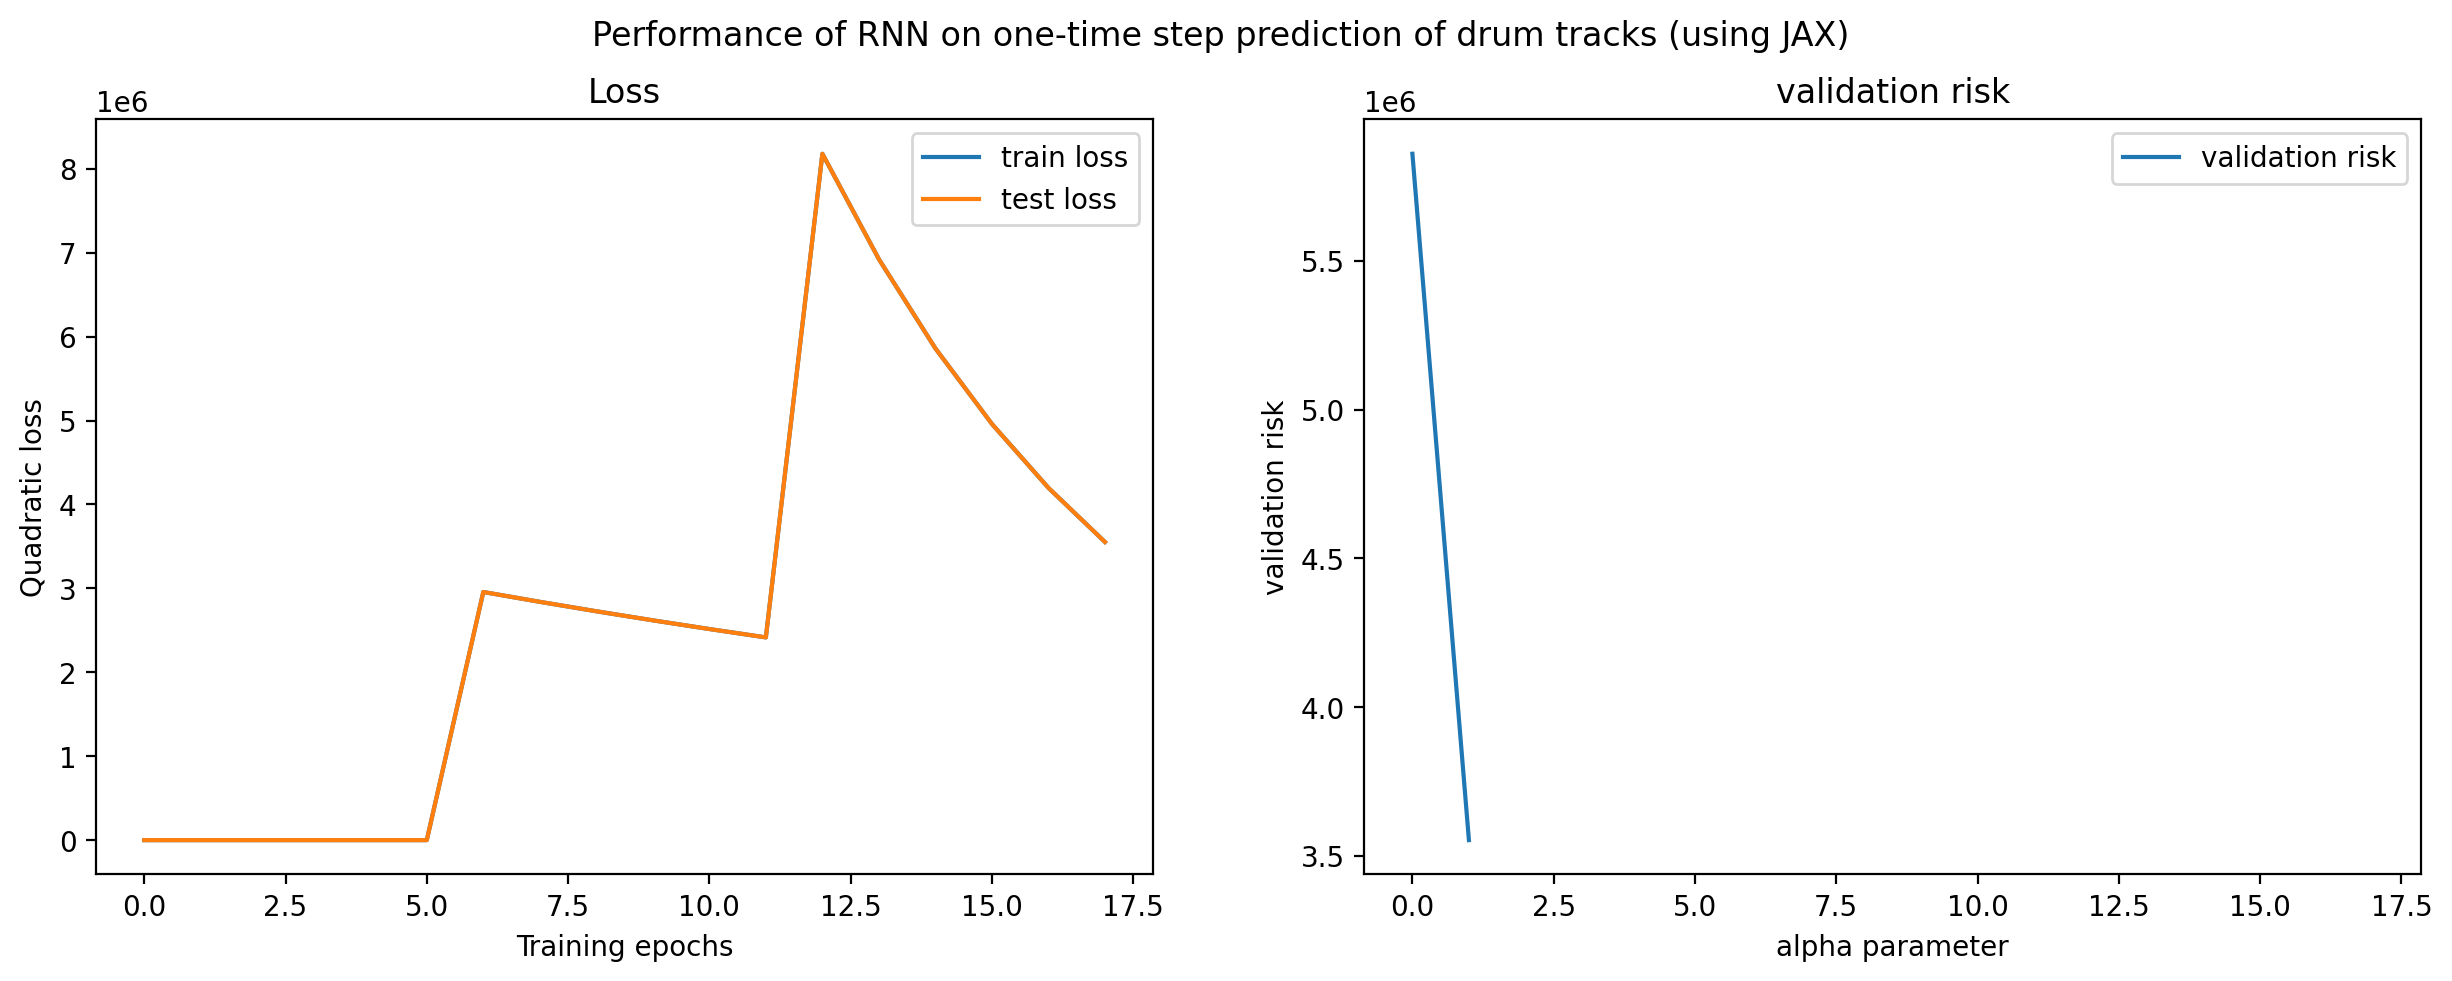

In [33]:
fig, axs = plt.subplots(ncols=2, nrows=1, dpi=200, figsize=(15,5), sharex=True)
fig.suptitle("Performance of RNN on one-time step prediction of drum tracks (using JAX)")
axs[0].set_title('Loss')
axs[0].plot(full_train_loss, label='train loss')
axs[0].plot(full_test_loss, label='test loss')
axs[0].set_ylabel('Quadratic loss')
axs[0].set_xlabel('Training epochs')
axs[0].legend()

axs[1].set_title('validation risk')
axs[1].plot(validation_risk_r, label='validation risk')
axs[1].set_ylabel('validation risk')
axs[1].set_xlabel('alpha parameter')
axs[1].legend()

plt.plot()

## Music Generation
Get the file to prime the network with

In [26]:
def apply_fun_scan(params, x, un):
    """ Perform single step update of the network.
    x:  (L, ) at time step n -> x: (L, ) at time step n+1
    un: (K, )
    """
    Win, W, Wout, b = params
    x = np.tanh(
        np.dot(Win, un) + np.dot(W, x) + b
    )
    y = jax.nn.sigmoid(np.dot(Wout, x))
    return x, y
"""
columnNames = ["track", "time", "control"
                                , "channel", "notes", "velocity"]

df1 = pd.read_csv('drumDemo.csv', skipfooter=2, skiprows=8, engine='python', names= columnNames)

u_prime = D(df1, h, maxTime)[0]
"""
u_prime = S[0][0]
n_stop = 1000
n_output = 4000

y_signal = []
x = np.zeros((L,))
for n in range(n_stop):
    x, y = apply_fun_scan(params, x, u_prime[n])
    y_signal.append(y)

for n in range(n_output):
    x, y = apply_fun_scan(params, x, y)
    y_signal.append(y)

print(y_signal)
dfo = D_inv(np.array(y_signal), h_inv)

[DeviceArray([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32), DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), DeviceArray([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32), DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), DeviceArray([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32), DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), DeviceArray([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32), DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), DeviceArray([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32), DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), DeviceArray([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32), DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

$$
\mathcal{M}^{-1} : \text{CSV} \rightarrow \text{MIDI}
$$

In [27]:
"""
Puts generated CSV file in correct folder
and generates the MIDI file and puts that in the correct
folder as well.
"""
# for debugging: checking highest amplitude in output signal
"""
v = -99999999999999
for e in y_signal:
    if e.max() >= v:
        v = e.max()
print(v)
"""

os.chdir('../midi/NetworkOutputCSV')
name = "rnn.csv"
dfo.to_csv(name, index = False, header = False)
copy(name, '../midicsv-1.1')
os.chdir('../midicsv-1.1')

command = "csvmidi" + " " + name + " " + name[:-4] + ".mid"
res = os.system(command)
print(res)
os.remove(name)
try:
    move(name[:-4] + ".mid", '../NetworkOutputMIDI')
except:
    print("midi file already here")
    os.remove(name[:-4] + ".mid")

os.chdir(cwd)




0
midi file already here


## Experimental: reservoir computing
dimensionality $K, L, K$ same: using same rnn.
First: scaling with spectral radius

In [28]:
if (RC_ON):
    W, Win, Wout, b = params
    rhoW = np.max(np.absolute(np.linalg.eig(W)[0]))
    scale = 1.25
    W = (scale/rhoW)*W

Step 1: state harvesting: record activation for each of the $L$ reservoir neurons
when driven by teacher input

In [29]:
def forward(u, Win, W, b, Wout=None, x_init=np.zeros((L, ))):
    # u: (n_max, K)
    n_max = u.shape[0]
    K = u.shape[1]
    X, Y = [], []
    # X: (1+K+L, n_max)
    # Y: (K, n_max) double chheck later
    x = x_init.copy()
    for t in range(u.shape[0]):
        x = np.tanh(
            np.dot(Win, u[t]) + np.dot(W, x) + b
        )
        full_state = np.concatenate(u[t], x, b)
        X.append(full_state)
        if Wout is not None:
            y = np.dot(Wout, full_state)
            Y.append(y)
        # when returning: need to transpose data arrays, such that dim: (n_max, x)
    if Wout is None:
        return x, np.array(X).T
    else:
        return x, np.array(X).T, np.array(Y).T

In [30]:
if (RC_ON):
    x, X = forward(u_train[0], Win, W)
    print(f'u: {u_train[0].shape}, x: {x.shape}, X: {X.shape}')

step 2: compute readouts

In [31]:
if (RC_ON):
    reg = 1e-8

    Wout_rc_ = np.dot(
        np.dot(y_train[0].T, X.T),
        np.linalg.inv(
            np.dot(X, X.T) + reg*np.eye(1+K+L)
        )
    )